# 第8章 統計的シミュレーション

## 選択問題及び部分記述問題 問13：メトロポリス・ヘイスティングス法

このノートブックでは、提供された問題（問13）の設定に基づき、メトロポリス・ヘイスティングス法（MH法）を用いた混合正規分布からのサンプリングをシミュレーションします。

### 問題の要約

*   **目標分布**: 混合正規分布
    $$\pi(x) = \frac{1}{4} N(0, 1) + \frac{3}{4} N(6, 1)$$
    
*   **アルゴリズム**: 酔歩連鎖によるメトロポリス・ヘイスティングス法
*   **目的**: 乱数 $x$ を 10000 個発生させる

### アルゴリズムの手順

1.  **Step 1**: 初期値 $x^{(0)} = 6$、$t \leftarrow 0$、ステップ幅パラメータ $\alpha = a$ を定める。
2.  **Step 2**: 提案分布から候補を生成する。
    $$\epsilon \sim U(-a, a)$$
    $$y = x^{(t)} + \epsilon$$
3.  **Step 3**: 採択確率 $\alpha(x^{(t)}, y)$ に基づいて更新する。
    $$u \sim U(0, 1)$$
    $$x^{(t+1)} = \begin{cases} y, & u \le \alpha(x^{(t)}, y) \\ x^{(t)}, & \text{それ以外} \end{cases}$$
    ここで、提案分布 $q(y|x)$ が対称（$U(-a, a)$）であるため、採択確率は以下のようになる。
    $$\alpha(x^{(t)}, y) = \min \left( 1, \frac{\pi(y)}{\pi(x^{(t)})} \right)$$
4.  **Step 4**: $t \leftarrow t + 1$
5.  **Step 5**: 
    *   $t \le 1000$ のとき、 $x^{(t)}$ は出力しない（バーンイン期間）。
    *   $1000 < t \le 11000$ のとき、 $x^{(t)}$ を出力する。
6.  **Step 6**: $t = 11000$ なら終了、それ以外なら Step 2 に戻る。

In [1]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.stats import norm
import matplotlib.font_manager as fm

# 日本語フォントの設定
try:
    font_path = '../fonts/ipaexg.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
except:
    print("Font file not found, using default font.")

%matplotlib inline

In [2]:
# 目標分布の確率密度関数 pi(x)
def target_pdf(x):
    # 1/4 N(0, 1) + 3/4 N(6, 1)
    return 0.25 * norm.pdf(x, 0, 1) + 0.75 * norm.pdf(x, 6, 1)

# メトロポリス・ヘイスティングス法のサンプラー
def mh_sampler(a, n_iterations=11000, burn_in=1000, initial_x=6):
    samples = []
    trace = []
    
    x = initial_x
    current_pdf = target_pdf(x)
    
    # 採択回数のカウント（採択率計算用）
    accepted_count = 0
    
    for t in range(1, n_iterations + 1):
        # 提案分布: y = x + epsilon, epsilon ~ U(-a, a)
        epsilon = np.random.uniform(-a, a)
        y = x + epsilon
        
        # 提案された点の確率密度
        proposal_pdf = target_pdf(y)
        
        # 採択確率 alpha
        # 提案分布が対称なので q(x|y) = q(y|x) となり、比は pi(y)/pi(x) となる
        alpha = min(1, proposal_pdf / current_pdf)
        
        # 採択判定
        u = np.random.rand()
        if u <= alpha:
            x = y
            current_pdf = proposal_pdf
            accepted_count += 1
        
        # 記録
        trace.append(x)
        if t > burn_in:
            samples.append(x)
            
    acceptance_rate = accepted_count / n_iterations
    return np.array(samples), np.array(trace), acceptance_rate

### シミュレーションの実行

問題文にあるように、ステップ幅パラメータ $a$ を $0.1, 1, 6$ の3通りで実行し、結果を比較します。

In [3]:
a_values = [0.1, 1, 6]
results = {}

np.random.seed(42) # 再現性のため

for a in a_values:
    print(f"Running simulation for a = {a}...")
    samples, trace, acc_rate = mh_sampler(a, initial_x=6)
    results[a] = {'samples': samples, 'trace': trace, 'acc_rate': acc_rate}
    print(f"  Acceptance Rate: {acc_rate:.2%}")

Running simulation for a = 0.1...
  Acceptance Rate: 97.95%
Running simulation for a = 1...
  Acceptance Rate: 80.97%
Running simulation for a = 6...
  Acceptance Rate: 34.81%


### 結果の可視化

各 $a$ の値について、トレースプロット（サンプルの推移）とヒストグラム（真の分布との比較）を表示します。

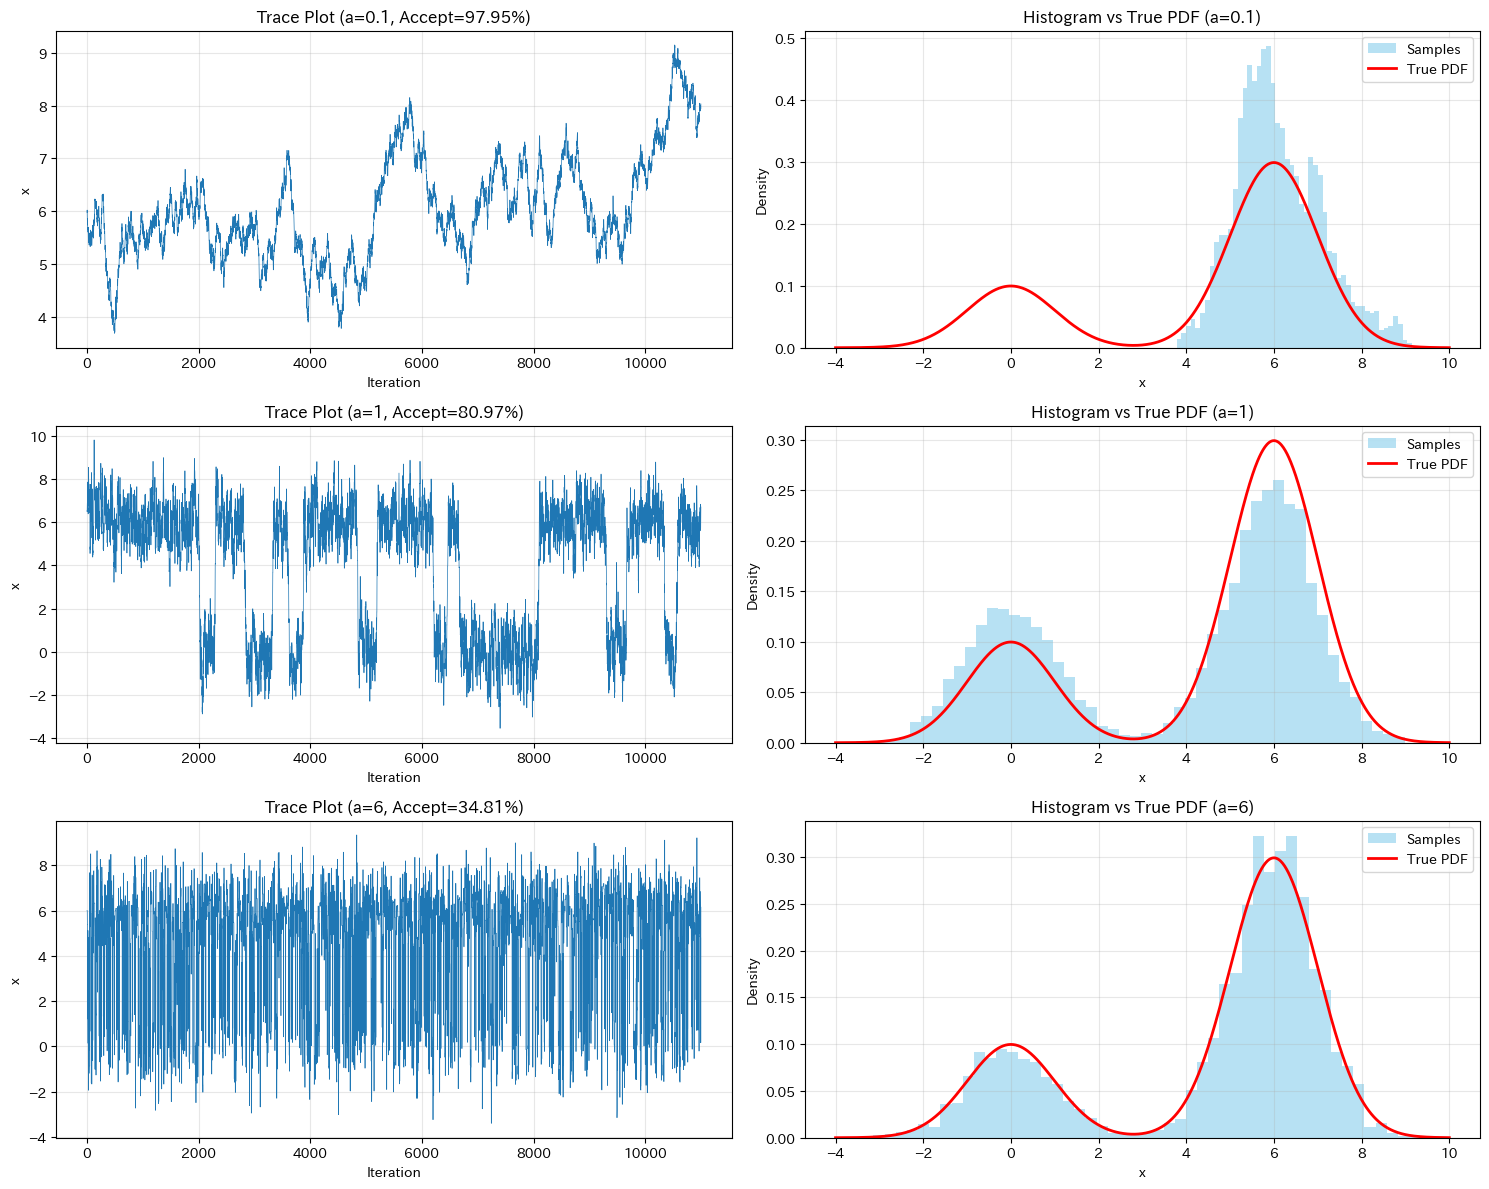

In [4]:
# 真の分布のプロット用データ
x_grid = np.linspace(-4, 10, 1000)
y_true = target_pdf(x_grid)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(15, 12))

for i, a in enumerate(a_values):
    data = results[a]
    
    # トレースプロット
    ax = plt.subplot(3, 2, 2*i + 1)
    ax.plot(data['trace'], lw=0.5)
    ax.set_title(f'Trace Plot (a={a}, Accept={data["acc_rate"]:.2%})')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('x')
    ax.grid(alpha=0.3)

    inset_ax = inset_axes(ax, width="35%", height="35%", loc="upper right", borderpad=1)
    inset_ax.hist(data['samples'], bins=30, density=True, alpha=0.6, color='skyblue', orientation='horizontal')
    inset_ax.plot(y_true, x_grid, 'r-', lw=1)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.grid(alpha=0.2)
    
    # ヒストグラムと真の分布
    plt.subplot(3, 2, 2*i + 2)
    plt.hist(data['samples'], bins=50, density=True, alpha=0.6, color='skyblue', label='Samples', orientation='horizontal')
    plt.plot(y_true, x_grid, 'r-', lw=2, label='True PDF')
    plt.title(f'Histogram vs True PDF (a={a})')
    plt.xlabel('Density')
    plt.ylabel('x')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 問題の考察

#### [1] 式の導出
目標分布の確率密度関数 $\pi(x)$ は既に与えられています。
$$\pi(x) = \frac{1}{4} \phi(x) + \frac{3}{4} \phi(x-6)$$
ここで $\phi(x)$ は標準正規分布の確率密度関数です。

提案分布は正規分布で対称なので、

$$y \mid x^{(t)} \sim N\left(x^{(t)}, a^2
\right), \quad y = x^{(t)} + a z,\ z\sim N(0,1)$$

となります。対称性 $q(y|x)=q(x|y)$ を使うと採択確率は

$$
\alpha\left(x^{(t)}, y
\right) = \min \left( 1, \frac{\pi(y)}{\pi(x^{(t)})} 
\right)
$$

で、比の中身を明示すると

$$
\frac{\pi(y)}{\pi(x^{(t)})}=\frac{\frac{1}{4}\phi(y) + \frac{3}{4}\phi(y-6)}{\frac{1}{4}\phi\left(x^{(t)}
\right) + \frac{3}{4}\phi\left(x^{(t)}-6
\right)}
$$

よって

$$
\alpha\left(x^{(t)}, y
\right)=\min \left( 1, \frac{\frac{1}{4}\phi(y) + \frac{3}{4}\phi(y-6)}{\frac{1}{4}\phi\left(x^{(t)}
\right) + \frac{3}{4}\phi\left(x^{(t)}-6
\right)} 
\right)
$$

となります。

#### [2] パラメータ $a$ と挙動の関係
シミュレーション結果（トレースプロットとヒストグラム）から、各 $a$ の挙動は以下のように解釈できます。

*   **$a=0.1$ の場合**: 
    *   ステップ幅が非常に小さいため、現在の位置から大きく動くことができません。
    *   初期値 $x=6$ の周辺（右側の山）にとどまり続けており、左側の山（$x=0$ 付近）へ移動できていません。
    *   **採択率**: 非常に高い（ほぼ 100% に近い）。提案された近傍の点は確率密度が近いため採択されやすいですが、混合（Mixing）が悪いです。

*   **$a=1$ の場合**:
    *   適度なステップ幅であり、 $x=6$ の山と $x=0$ の山の間を行き来できています。
    *   ヒストグラムも真の分布をよく再現しています。
    *   **採択率**: 適度な値（一般的に 20%~50% 程度が良いとされることが多いですが、この単純なケースでは 50-70% 程度でも良好です）。

*   **$a=6$ の場合**:
    *   ステップ幅が大きいため、現在の位置から遠く離れた、確率密度の低い領域を提案することが多くなります。
    *   その結果、棄却されることが多くなり、同じ値にとどまる期間（トレースプロットでの平坦な部分）が長くなります。
    *   **採択率**: 低い。

#### [3] バーンイン（Burn-in）について
**質問**: Step 5 で $x^{(1)}, ..., x^{(1000)}$ を出力に加えない理由を説明せよ。

**回答**: 
マルコフ連鎖モンテカルロ法（MCMC）では、連鎖の初期状態は初期値 $x^{(0)}$ の影響を強く受けており、目標分布 $\pi(x)$ からのサンプリングとはみなせません。十分なステップ数を経て連鎖が定常分布（目標分布）に収束するのを待つ必要があります。この収束までの期間を**バーンイン（Burn-in）**と呼び、この期間のサンプルを破棄することで、初期値依存性を排除し、より正確に目標分布に従うサンプルを得ることができます。

実際に推定したい量 $\mathbb{E}_{\pi}[f(X)]$ は、バーンイン後のサンプルで

$$
\hat{\mu}_f = \frac{1}{N}\sum_{t=B+1}^{B+N} f\left(x^{(t)}
\right)
$$

のように推定するため、$B$ ステップの破棄は初期値の偏りを減らすための処理になります。
